# Principal Component Analysis
Certain parts of this lab were kindly taken from the [Deep Learning Book tutorials](https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.12-Example-Principal-Components-Analysis/).

As an introductory example for PCA we will create again a two dimensional dataset. To see the effect of the PCA we will introduce some correlations between the two dimensions. Let us generate 100 data points with 2 dimensions, where the $y$ dimension is a noised version of $x$.

In [79]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt

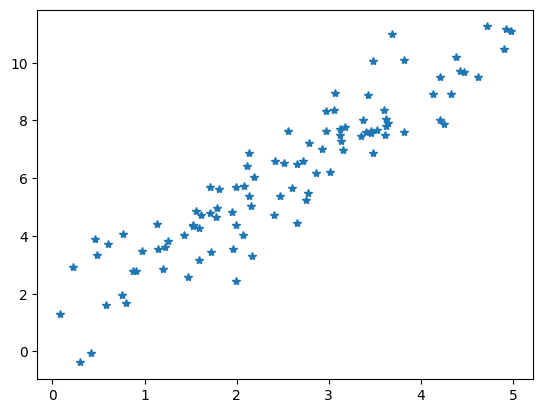

In [80]:
np.random.seed(123)
nobs = 100
x = 5*np.random.rand(nobs)
y = 2*x + 1 + np.random.randn(nobs)

x = x.reshape(nobs, 1)
y = y.reshape(nobs, 1)

X = np.hstack([x, y])
plt.plot(X[:,0], X[:,1], '*')
plt.show()

Highly correlated data means that the dimensions are almost redundant. It is possible to predict one from the other without losing much information.

The first processing we will do is to center the data around 0. PCA is a regression model without intercept (see here) and the first component is thus necessarly crossing the origin.

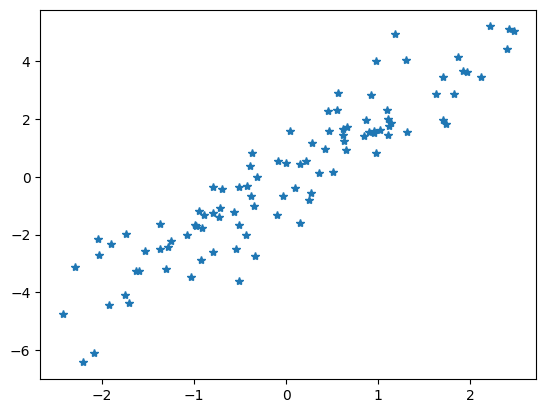

In [81]:
X_centered = X - np.mean(X, axis = 0)
plt.plot(X_centered[:,0], X_centered[:,1], '*')
plt.show()

Now, we will look do the eigendecomposition of the covariance matrix. How do we compute the covariance matrix from our data? Well, it is quite simple.
The equation for an element $c_{ij}$ of a sample covariance matrix is:
$c_{ij}= \frac{1}{n-1}{ (X_{j} - \bar{X}_j)^T(X_{i} - \bar{X}_i) }$, where $\bar{X_j}$ is the mean of $i$-th column.


In [82]:
cov_matrix = 1/(X_centered.shape[0]-1) * ( X_centered.T @ X_centered)
np.array_equal(cov_matrix, np.cov(X.T))

True

The covariance matrix is a symmetric matrix. Do you remember the statement below from the eigendecomposition?

For symmetric matrices, the eigendecomposition can be expressed as
$A = Q  \Lambda Q^{-1}$, where $\Lambda$ is the diagonal matrix containing all the eigenvalues. Note, that this does not require the inverse matrix, as $Q$ is an orthonormal matrix and thence $Q^{-1} = Q^T$.

We will utilize this and calculate the eigenvectors, which tell us in which directions data varies the most.

In [83]:
eigVals, eigVecs = np.linalg.eig( cov_matrix )
print(f"eigenvectors:\n {eigVecs}")
print(f"eigenvalues:\n {eigVals}")
eigVecs = eigVecs[:,np.argsort(-eigVals)]

print(f"sorted eigenvectors:\n {eigVecs}")

eigenvectors:
 [[-0.91116273 -0.41204669]
 [ 0.41204669 -0.91116273]]
eigenvalues:
 [0.182296   8.06416594]
sorted eigenvectors:
 [[-0.41204669 -0.91116273]
 [-0.91116273  0.41204669]]


These are orthonormal vectors pointing to the directions which maximize the variance. Each column vector is associated with an eigenvalue. The vector associated with the largest eigenvalue tells us the direction associated with the larger variance in our data. The size of the eigenvalue is proportional to the explained variance by the vector.

In [84]:
#@title Vector plotting function (just run the code) { display-mode: "form" }
def plotVectors(vecs, cols, alpha=1):
    plt.figure()
    plt.axvline(x=0, color='#A9A9A9', zorder=0)
    plt.axhline(y=0, color='#A9A9A9', zorder=0)

    for i in range(len(vecs)):
        x = np.concatenate([[0,0],vecs[i]])
        plt.quiver([x[0]],
                   [x[1]],
                   [x[2]],
                   [x[3]],
                   angles='xy', scale_units='xy', scale=1, color=cols[i],
                   alpha=alpha)

Below are displayed the PCA direction vectors. The orange shows the direction of first principal component and the blue of the second componend. We can see, that the orange points towards the largest variance. Do not forget to run the hidden cell above to obtain the `plotVectors` function.

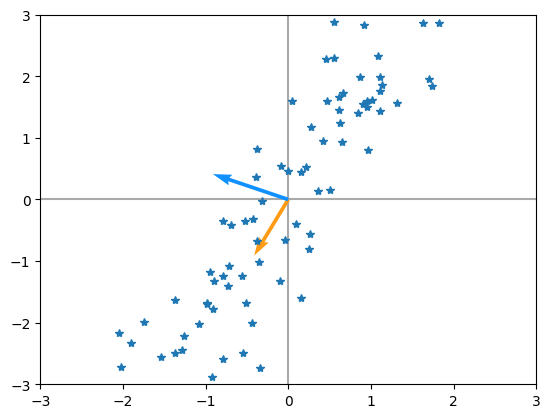

In [85]:
orange = '#FF9A13'
blue = '#1190FF'
plotVectors(eigVecs.T, [orange, blue])
plt.plot(X_centered[:,0], X_centered[:,1], '*')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

Now we know the direction minimizing the variance. As the next step, we need to project all the points to a new dimensions, by multiplying the eigenvectors with the centered data matrix, as shown in `X_new`. The $y$ axis now corresponds to the dimension capturing most of the variance. So if we would like to reduce the dimension of the data to a single dimension, we would just take the 2nd column of `X_new` corresponding to the $y$ axis on the plot.

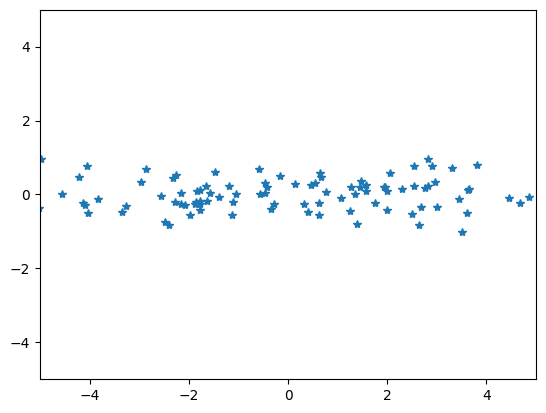

In [86]:
X_new = eigVecs.T @ X_centered.T

plt.plot(X_new[0, :], X_new[1, :], '*')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

## A function for computing PCA
The task now is to write a function that will compute PCA based on the instructions above. Run the cell below to generate the data.

In [87]:
#@title Code generating the data { display-mode: "form" }
np.random.seed(123)
nobs = 60
covmat =  np.array([[1, 0.95, 0.92, 0.35], [0.95, 1 , 0.93, 0.4], [0.92, 0.93, 1, 0.3], [0.35, 0.4, 0.3, 1]])
X = np.random.multivariate_normal(mean = [0, 0, 0, 0], cov = covmat, size = 4 * nobs)
X[:,0] = X[:,0]* 3 + 4
X[:,1] = X[:,1]* 2 + 20
X[:,3] = X[:,3]* 4 + 100

First, we plot the data. On the plot below, you can see that there is a high dependence between the first three columns, except the 4th column. So we can try to reduce this 4 dimensional space into 2 dimensions and then visualize it. We will notice that the first three dimensions are quite correlated as the points grow together close to each other.

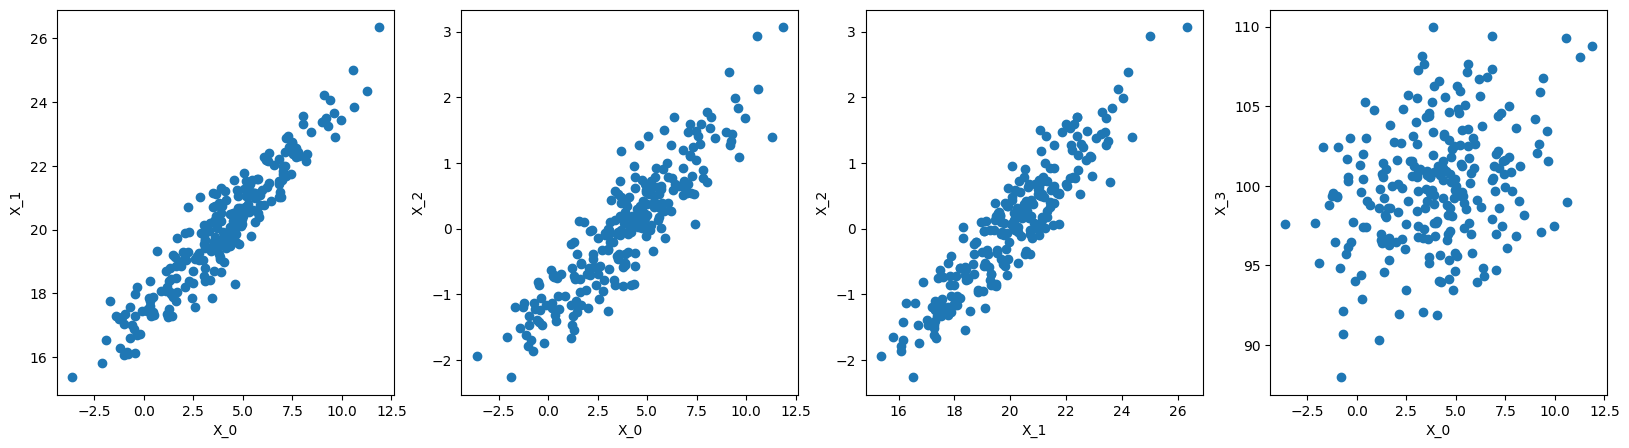

In [88]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,5))
ax1.scatter(X[:,0], X[:,1])
ax1.set(xlabel='X_0', ylabel='X_1')

ax2.scatter(X[:,0], X[:,2])
ax2.set(xlabel='X_0', ylabel='X_2')

ax3.scatter(X[:,1], X[:,2])
ax3.set(xlabel='X_1', ylabel='X_2')

ax4.scatter(X[:,0], X[:,3])
ax4.set(xlabel='X_0', ylabel='X_3')
plt.show()

Using this tutorial and with the help of this data we will reduce the dimensions of this space in the following steps:
1. First, we calculate the Gram matrix
2. We apply the eigendecomposition to the Gram matrix.
3. We order the eigenvectors by the eigenvalues from largest to smallest, so the dimensions providing the most variance are first. Here, you need to do the reorder.
4. Finally, we transform the original data using the sorted eigenvectors to the new orthogonal basis.

In [89]:
# 1st step
C = X.T @ X
# apply eigendecomposition
eigVals, eigVecs = np.linalg.eig(C)
# sorts the eigenvalues and eigenvectors
eigenV_order = np.argsort(-eigVals)
eigVecs = eigVecs[:,eigenV_order] # order the eigenvectors
eigVals = eigVals[eigenV_order] # order the eigenvalues
# transform the data to the new basis
X_pca = X @ eigVecs

Let us check out what we have computed.

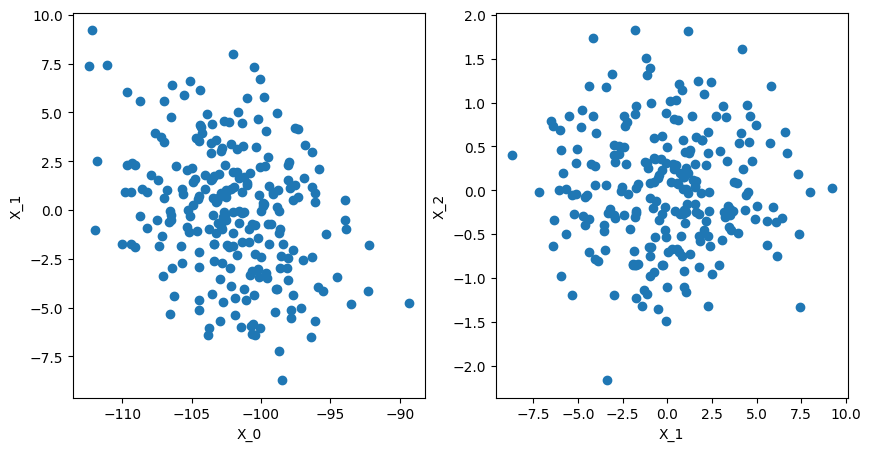

In [90]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.scatter(X_pca[:,0], X_pca[:,1])
ax1.set(xlabel='X_0', ylabel='X_1')

ax2.scatter(X_pca[:,1], X_pca[:,2])
ax2.set(xlabel='X_1', ylabel='X_2')
plt.show()

The data on the scatterplots looks like it is not much dependent. Let us chceck the correlation matrix!

In [91]:
print(np.corrcoef(X_pca.T))

[[ 1.00000000e+00 -3.05891034e-01  5.89251453e-01 -3.36230611e-01]
 [-3.05891034e-01  1.00000000e+00  2.74720869e-04 -1.56757468e-04]
 [ 5.89251453e-01  2.74720869e-04  1.00000000e+00  3.01968856e-04]
 [-3.36230611e-01 -1.56757468e-04  3.01968856e-04  1.00000000e+00]]


Oops, It contains even some higher values close to $0.6$! This suggests that we maybe have forgotten something. Can you identify what we have forgotten?

### Standardizing data for PCA

Oh yes, we did not center the data. Please use [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) from `sklearn.preprocessing` module to your data. It works similar to `MinMaxScaler` and contains `fit_transform` method as well. To omit the scaling, set the `with_std` parameter to `False` in the constructor.
You could also divide the Gram matrix $X^T X$ by $n$ to obtain the covariance matrix, but this only scales all the components, hence we can skip this step.


Then apply the same procedure as above and do not forget to reorder eigenvectors and eigenvalues.

In [92]:
from sklearn.preprocessing import StandardScaler

# add the code for PCA here
scaler = StandardScaler(with_std=False)
X_scaled = scaler.fit_transform(X)

C = X_scaled.T @ X_scaled
# apply eigendecomposition
eigVals, eigVecs = np.linalg.eig(C)
eigenV_order = np.argsort(-eigVals)
eigVecs = eigVecs[:,eigenV_order] # order the eigenvectors
eigVals = eigVals[eigenV_order]
X_pca = X_scaled @ eigVecs

np.corrcoef(X_pca.T)

array([[ 1.00000000e+00,  3.47308736e-16, -2.71512937e-15,
         1.38882027e-15],
       [ 3.47308736e-16,  1.00000000e+00, -1.00321649e-15,
         1.54150764e-15],
       [-2.71512937e-15, -1.00321649e-15,  1.00000000e+00,
        -1.61105482e-15],
       [ 1.38882027e-15,  1.54150764e-15, -1.61105482e-15,
         1.00000000e+00]])

The eigenvalues are proportional to explained variance of the components. Try to calculate percentual proportion explaied by each compoment using the eigenvalues stored in `eigVals`.

In [93]:
explained_variance_ratio = eigVals / sum(eigVals) # calculate the percentual proportion.

The plot below plots the variance ratio.

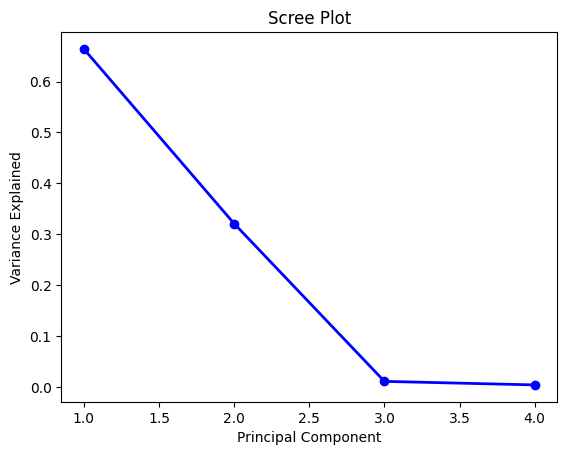

In [94]:
plt.plot(np.arange(len(eigVals))+1, explained_variance_ratio, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

# Principal component analysis with *sklearn*
In this notebook we will apply Principal component analysis (PCA) from `sklearn` library. Below, we load the required libraries.

In [95]:
from sklearn import datasets
import pandas as pd

We will use the well known iris dataset describing the iris flowers and the three classes of irises based on sepal and petal dimensions. The image below depicts iris with sepals and petals ([image source](https://kedro.readthedocs.io/en/0.17.5/_images/iris_measurements.png)).

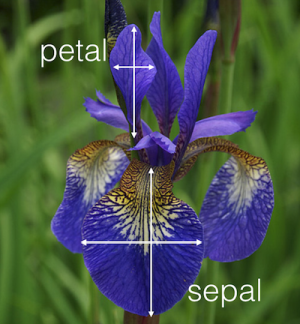

In [96]:
iris = datasets.load_iris()
iris_df = pd.DataFrame(iris.data, columns = ["sepal_length", "sepal_width", "petal_length", "petal_width"])
iris_df["target"] = iris.target
iris_df

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


To display all the sepal and petal dimensions, we need 6 scatterplots. But do we really need so many plots to provide a good-enough visualization of the data?

<Axes: xlabel='petal_length', ylabel='petal_width'>

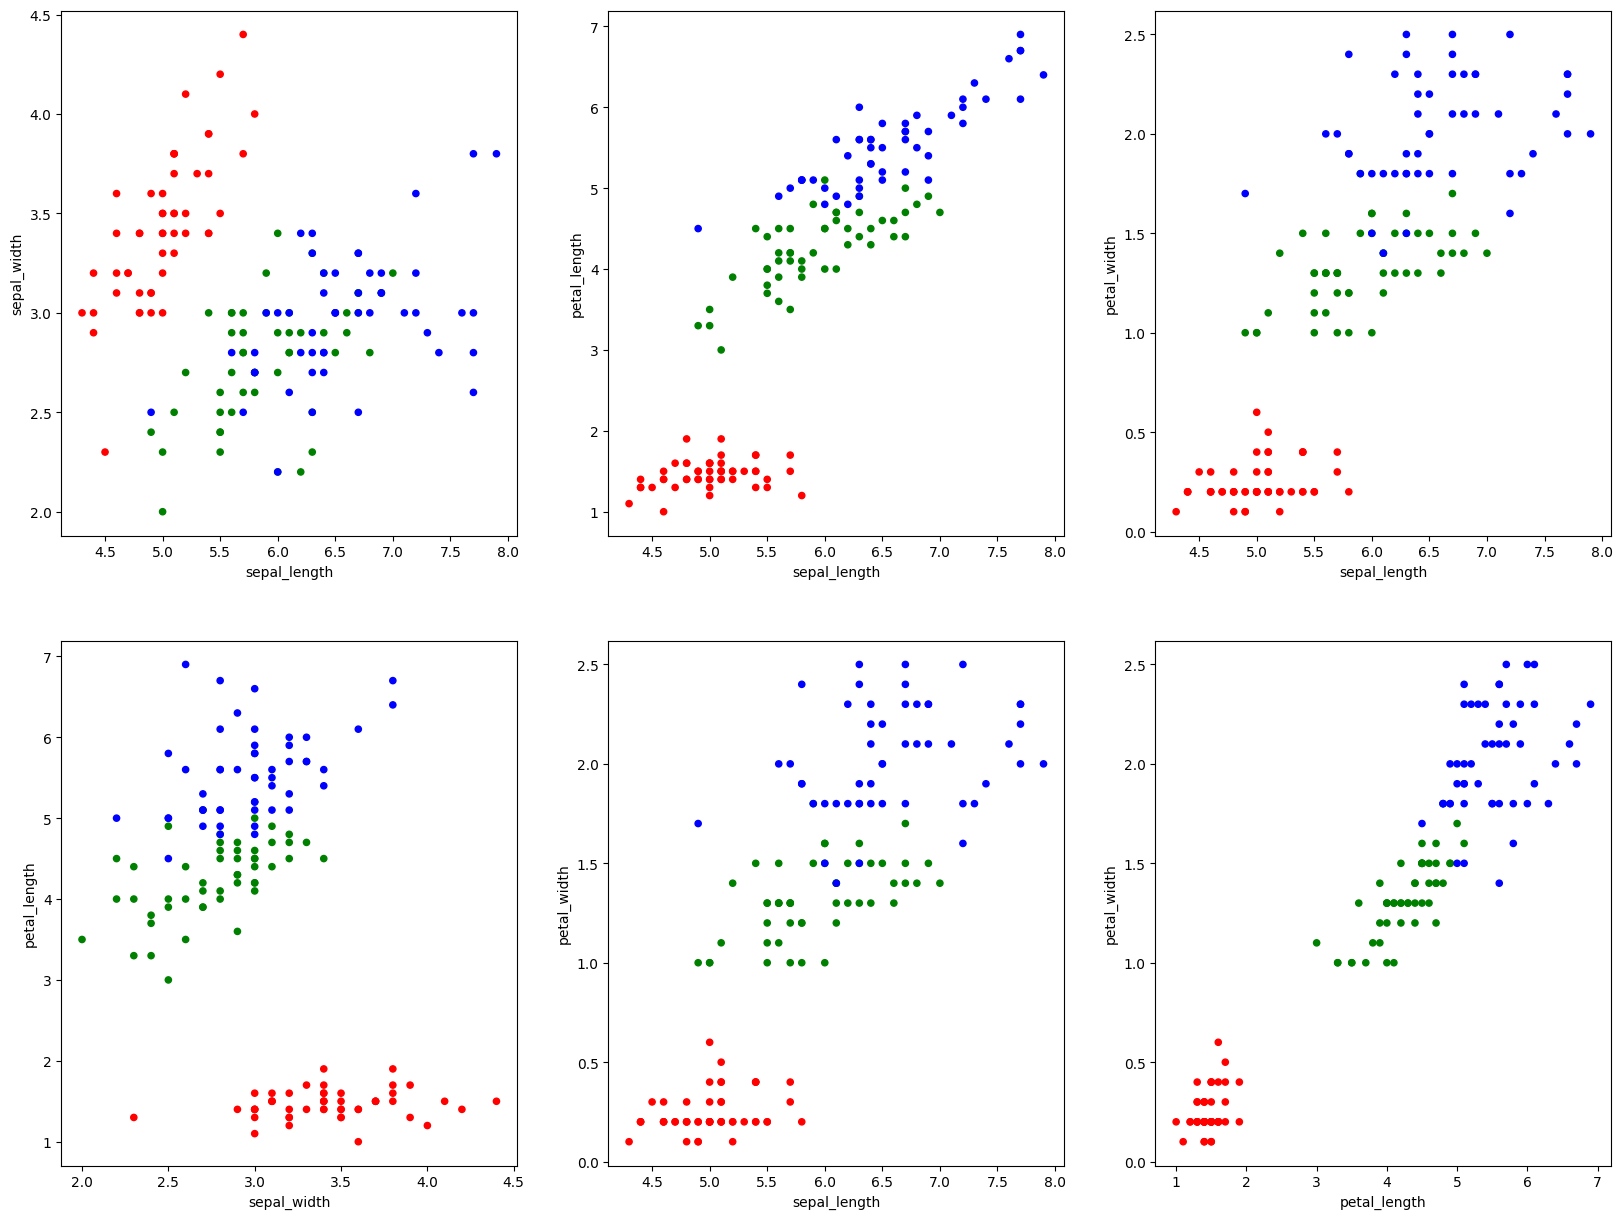

In [97]:
fig, ax = plt.subplots(2,3, figsize=(20,15))

colors = iris_df["target"].map({0:'red', 1:'green', 2:'blue'})

iris_df.plot.scatter(x='sepal_length',y='sepal_width', c=colors, ax=ax[0,0])
iris_df.plot.scatter(x='sepal_length',y='petal_length', c=colors, ax=ax[0,1])
iris_df.plot.scatter(x='sepal_length',y='petal_width', c=colors, ax=ax[0,2])
iris_df.plot.scatter(x='sepal_width',y='petal_length', c=colors, ax=ax[1,0])
iris_df.plot.scatter(x='sepal_length',y='petal_width', c=colors, ax=ax[1,1])
iris_df.plot.scatter(x='petal_length',y='petal_width', c=colors, ax=ax[1,2])

This week, we will use [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) implementation from sklearn's decopmposition package. The method has again implemented the `fit`, `transform` and `fit_transform` methods. Your task is to create a PCA object with `n_components`.

In [98]:
from sklearn.decomposition import PCA

n_components = 4
# create a PCA object
pca = PCA(n_components=n_components) # PCA constructor with number of components
X = pca.fit_transform(iris_df.iloc[:,0:4])
y = iris_df.target

Here, we do a 3D visualization of the main 3 components, where each color corresponds to different species.

3D visualizations may look good, but they are not recommended to be used for  data visualisation as they tend to be mislearing. Here we use it just for demonstrational purposes.  

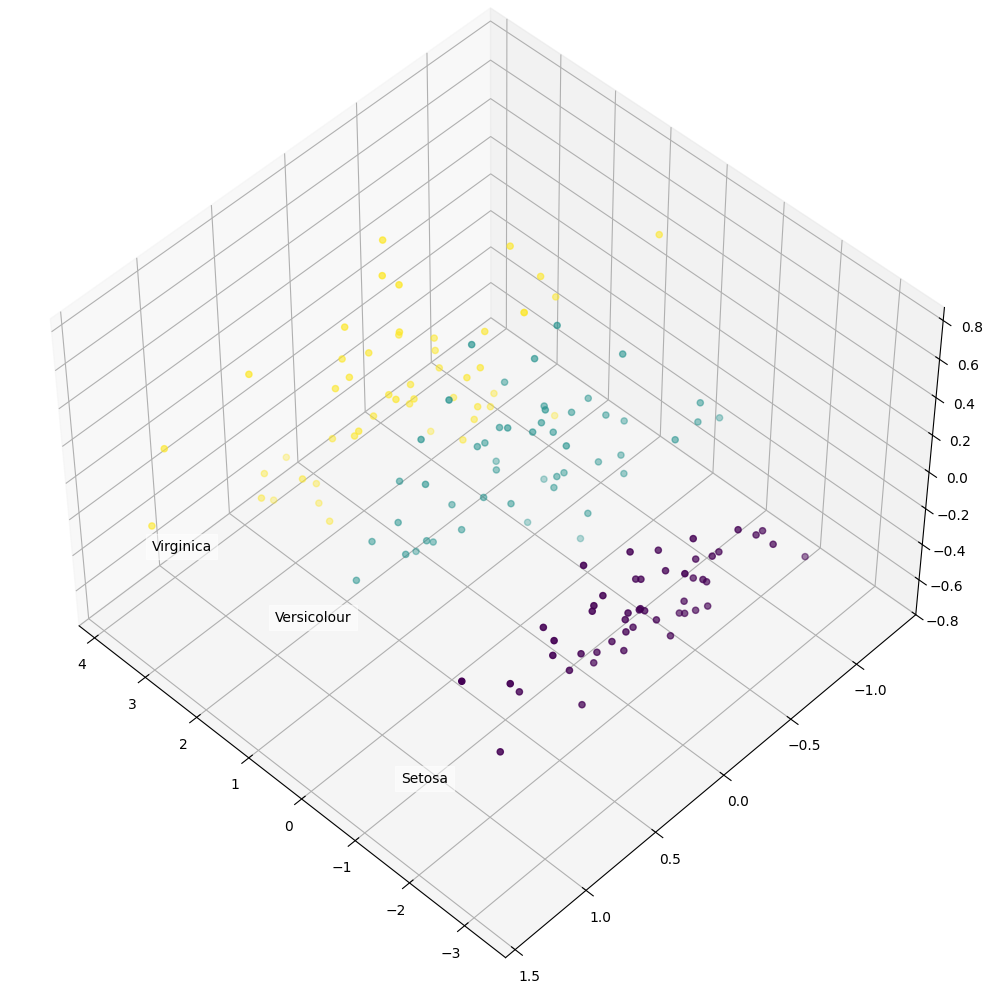

In [99]:
fig = plt.figure(1, figsize=(10, 10))
plt.clf()

ax = fig.add_subplot(111, projection="3d", elev=48, azim=134)
ax.set_position([0, 0, 0.95, 1])

plt.cla()
for name, label in [("Setosa", 0), ("Versicolour", 1), ("Virginica", 2)]:
    ax.text3D(
        X[y == label, 0].mean(),
        X[y == label, 1].mean() + 1.5,
        X[y == label, 2].mean(),
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.5, edgecolor="w", facecolor="w"),
    )
# order the results and add color mapping
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y)


plt.show()

To see the proportion of variance that each component explains, we will again use the scree plot.

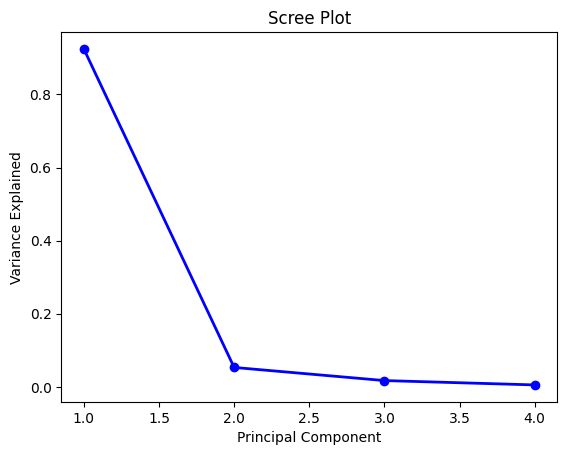

In [100]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

If you look at the 3D plot, you may notice that even 2 dimensions could describe the data well.
Finish the visualisation below and display the data using just the first two components. Add a scatter plot  of the first two components, which we assigned to the `X` attribute, with the following parameters: `c=y` and `cmap=colors`.

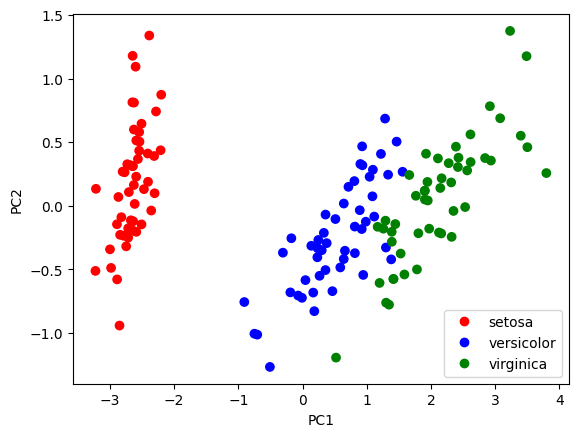

In [101]:
from matplotlib.colors import ListedColormap

colors = ListedColormap(['r','b','g'])
# add scatter plot of the first two components, c=y and cmap = colors
scatter = plt.scatter(X[:,0], X[:,1], c = y, cmap=colors)
# add legend
plt.legend(handles=scatter.legend_elements()[0], labels=list(iris.target_names))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Below display the data for the 2nd and 3rd component. Do not forget to use the right index to subset `X`.

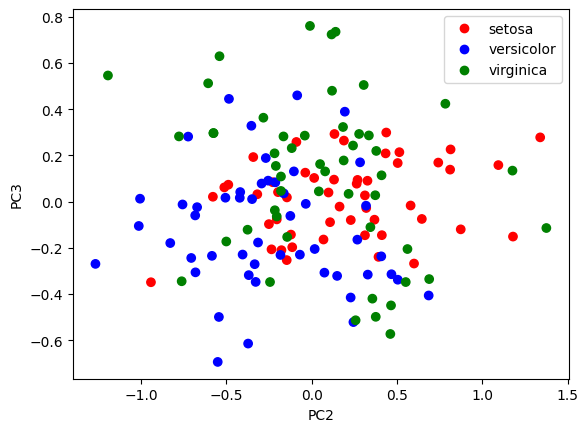

In [102]:
scatter = plt.scatter(X[:,1], X[:,2], c=y, cmap=colors)
plt.legend(handles=scatter.legend_elements()[0], labels=list(iris.target_names))
plt.xlabel("PC2")
plt.ylabel("PC3")
plt.show()

On the scatter plot above we see that it is very hard to separate the classes based on the 2nd and 3rd component. This tells us, that most likely the 1st component contains all the important information.

Finish the for loop below printing the percentage, that how much variance explains each component (`explained_variance_ratio_`).

In [103]:
for i in range(n_components):
  print(f"{i+1}. component explains {(pca.explained_variance_ratio_[i]*100):.2f}% of variance in the data.")

1. component explains 92.46% of variance in the data.
2. component explains 5.31% of variance in the data.
3. component explains 1.71% of variance in the data.
4. component explains 0.52% of variance in the data.


Each principal component is a linear combination of the original features, so the `components_` attribute contains the transformation matrix from canonical basis to the new orthogonal basis.
The following code displays the transformation matrix. Which column is contained the least in the first principal component? Print the name of the component below.

In [104]:
pd.DataFrame(pca.components_.T, columns=[f"PC{i}"for i in range(1,5)], index=iris.feature_names)

,PC1,PC2,PC3,PC4
sepal length (cm),0.361387,0.656589,-0.582030,0.315487
sepal width (cm),-0.084523,0.730161,0.597911,-0.319723
petal length (cm),0.856671,-0.173373,0.076236,-0.479839
petal width (cm),0.358289,-0.075481,0.545831,0.753657


In [105]:
print("The column contained the least in the first component is:")

The column contained the least in the first component is:


Why has the component such a low coefficient? Well, try to inspect the correlation of the original variables using `np.corrcoef` and you will notice, that `sepal_length`, `petal_length`, `petal_width` are highly correlated, but uncorrelated with `sepal_width`. To inspect the correlation, extract the first 4 columns of the dataframe and use `.corr()` method on the extracted dataframe.

In [106]:
# add your code here
np.corrcoef(iris_df.iloc[:,0:4].T)

array([[ 1.        , -0.11756978,  0.87175378,  0.81794113],
       [-0.11756978,  1.        , -0.4284401 , -0.36612593],
       [ 0.87175378, -0.4284401 ,  1.        ,  0.96286543],
       [ 0.81794113, -0.36612593,  0.96286543,  1.        ]])

The PCA does linear combinations, so highly correlated features are going to end up together in a component, where each uncorrelated feature will most likely represent a high proportion of an individual component.